In [382]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, contingency
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [370]:
file_path = "AB_Test_Results.csv"

# Load the latest version of the file
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sergylog/ab-test-data",
  file_path,
)

df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [371]:
# Drop duplicated rows
df = df.drop_duplicates(subset=['USER_ID', 'REVENUE']).reset_index(drop=True)

In [372]:
df['has_churned'] = [0 if row > 0 else 1 for row in df['REVENUE']]

Create synthetic data:

In [373]:
np.random.seed(42)
n = 2000
income_bracket = np.random.choice(
    ['<50k', '50k-99k', '100k-149k', '150k-199k', '>200k'],
    size = n,
    p = [0.25,0.30,0.25,0.15,0.05]
)

# Create other variables from survey using both the Kaggle data and synthetic data

current_status = df['has_churned'].sample(n=n, replace=True) # from the Kaggle dataset

# Internal factors 
benefit_value = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
customer_service = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
product_variety = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
membership_fee = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])

# External factors (scale 1–5)
inflation_pressure = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
trend_switching = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])
competition = np.random.choice(range(5), size = n, p=[0.25, 0.25, 0.30, 0.15, 0.05])

# NPS score (scale 0–10)
nps_score = np.random.choice(range(11), size = n, p=[0.02, 0.02, 0.03, 0.04, 0.06, 0.08, 0.12, 0.15, 0.23, 0.20, 0.05])

# Churn reason and dict 
churn_dict = {
    0: 'Membership not worth the cost',
    1: 'Did not use benefits enough',
    2: 'Poor customer service',
    3: 'Lack of product variety',
    4: 'Found better alternative',
    5: 'Budget concerns due to inflation',
    6: 'Seeking new brands',
    7: 'Other',
    8: 'N/A'
}

# Create dataframe
survey_df = pd.DataFrame({
    'Income': income_bracket,
    'Status': current_status,
    'BenefitValue': benefit_value,
    'CustomerService': customer_service,
    'ProductVariety': product_variety,
    'MembershipFee': membership_fee,
    'InflationPressure': inflation_pressure,
    'TrendSwitching': trend_switching,
    'Competition': competition,
    'NPS': nps_score,
})

survey_df['ChurnReason'] = [int(np.random.randint(low=0,high=8,size=1)) if row==1 else 8 for row in survey_df['Status']]

survey_df = survey_df.reset_index(drop=True)
survey_df['Condition'] = survey_df.index.map(lambda i: 'Treatment' if i % 2 == 0 else 'Control')


In [374]:
survey_df.describe()

,Status,BenefitValue,CustomerService,ProductVariety,MembershipFee,InflationPressure,TrendSwitching,Competition,NPS,ChurnReason
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.973500,1.480500,1.492500,1.527000,1.496500,1.51800,1.516000,1.473500,6.715000,3.703000
std,0.160657,1.138098,1.149611,1.159286,1.151803,1.15297,1.165943,1.151504,2.351497,2.366345
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.750000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,5.000000,2.000000
50%,1.000000,1.000000,1.000000,2.000000,1.000000,2.00000,2.000000,1.000000,7.000000,4.000000
75%,1.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,8.000000,6.000000
max,1.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,10.000000,8.000000


We now generate some visualizations: 

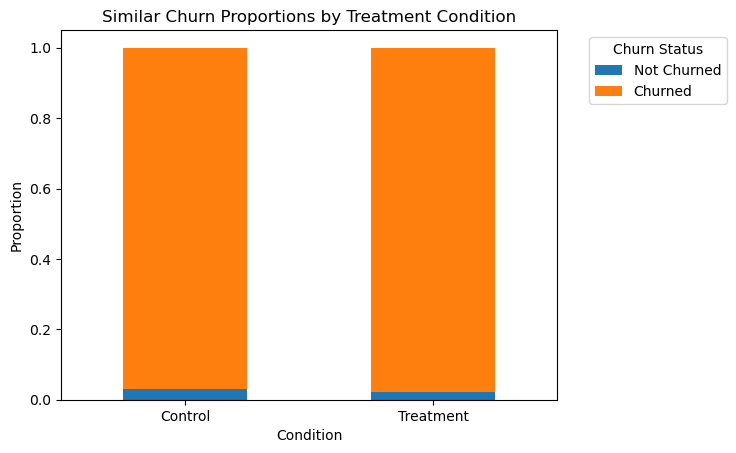

In [375]:
# Plot the proportion of status in the treatment and control groups
props = survey_df.groupby(['Condition','Status']).agg({'Status':'count'})
group_sum = props.groupby('Condition').sum()
props = props.div(group_sum, level = 'Condition')
props = props.rename(columns = {'Status': 'Proportion'})
props = props.reset_index()
props = props.pivot(index='Condition', columns='Status', values='Proportion')

props.plot(kind='bar', stacked=True)
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.title('Similar Churn Proportions by Treatment Condition')
plt.legend(labels=['Not Churned','Churned'], title='Churn Status', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()

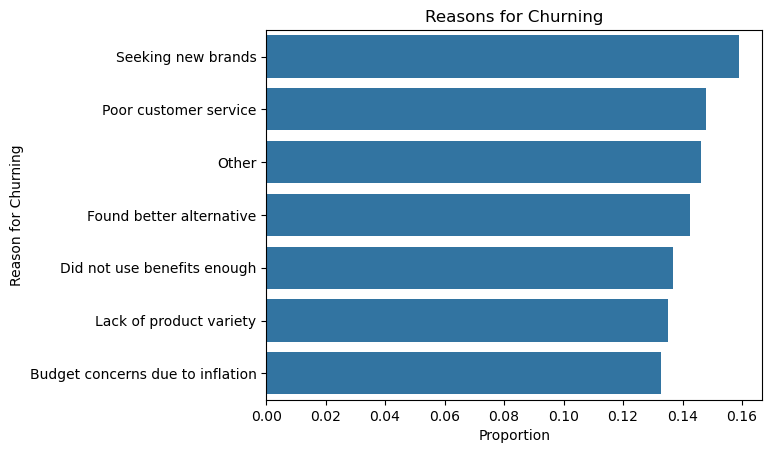

In [376]:
# Plot proportion of churn reasons
churn_reasons = survey_df['ChurnReason'].value_counts()
churn_reasons = churn_reasons[0:7,]
churn_reasons = churn_reasons.reset_index()
churn_reasons['Reason'] = churn_reasons['ChurnReason'].map(churn_dict)
churn_reasons = churn_reasons.drop(columns='ChurnReason')
churn_reasons['Prop'] = churn_reasons['count'] / churn_reasons['count'].sum()
fig,ax=plt.subplots()
sns.barplot(data=churn_reasons, x='Prop', y='Reason')
plt.ylabel("Reason for Churning")
plt.xlabel("Proportion")
plt.title("Reasons for Churning")
plt.show()

In [377]:
# Calculate net promoter score
n_promoters = len(survey_df.loc[survey_df['NPS'] > 8])
n_detractors = len(survey_df.loc[survey_df['NPS'] <= 6])
NPS = (n_promoters - n_detractors) / len(survey_df)
print(f"Our Net Promoter Score (NPS) is: {NPS}")

Our Net Promoter Score (NPS) is: -0.133


We now cross-tabulate churn reasons with income level: 

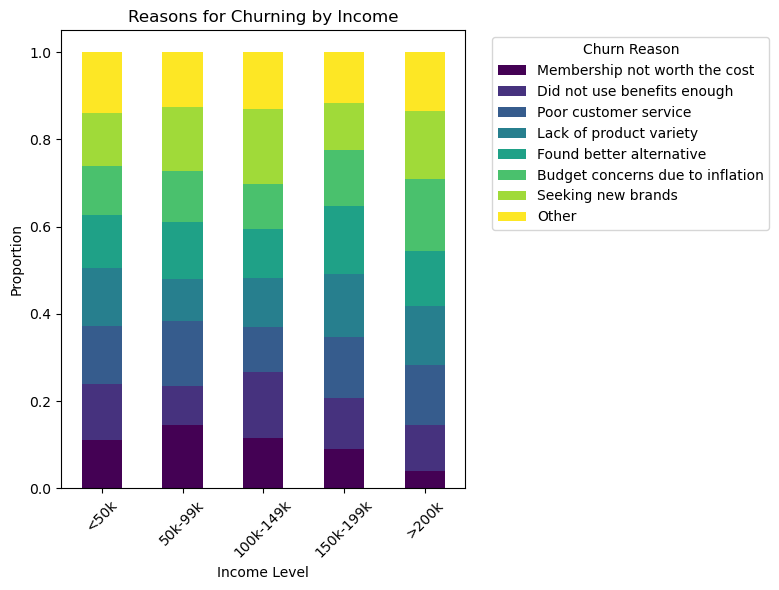

In [378]:
# Create a cross-tabulation of churn reasons vs. income level: 
x_tab = pd.crosstab(survey_df['Income'], survey_df['ChurnReason'])
x_tab = x_tab.drop(columns=8)
order = [3,2,0,1,4] # Reorder income in ascending order
x_tab = x_tab.iloc[order]
x_tab_norm = x_tab.div(x_tab.sum(axis=1), axis=0)


# Plot the cross-tabulation as a stacked barplot
ax = x_tab_norm.plot(kind='bar', stacked='True', figsize=(8,6), colormap='viridis')
plt.ylabel('Proportion')
plt.title('Reasons for Churning by Income')
plt.xlabel('Income Level')
plt.xticks(rotation=45)
plt.legend(labels = x_tab_norm.columns.map(churn_dict), title="Churn Reason", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()